In [42]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [47]:
#将时间机器的文本数据导入进来
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [48]:
train_iter

In [49]:
vocab

In [50]:
# 独热编码
# 在train_iter中，每个词元都表示为一个数字索引， 
# 将这些索引直接输入神经网络可能会使学习变得困难。 
# 我们通常将每个词元表示为更具表现力的特征向量。 
# 最简单的表示称为独热编码（one-hot encoding）
# PyTorch 中用于将类标签转换为独热编码的函数（one-hot encoding）

F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [51]:
# 我们每次采样的小批量数据形状是二维张量： （批量大小，时间步数）
# one_hot函数将这样一个小批量数据转换成三维张量， 
# 张量的最后一个维度等于词表大小（len(vocab)）

# 创建一个张量 X，包含数字 0 到 9，并重塑为 (2, 5) 的形状
X = torch.arange(10).reshape((2, 5))
# 转置张量，变成 (5, 2) 的形状
# X.T 返回的是 X 的转置
# 然后对转置后的张量进行独热编码，指定类别数为 28
one_hot_encoded = F.one_hot(X.T, 28)


one_hot_encoded.shape
# 时间，批量，特征长度

torch.Size([5, 2, 28])

In [52]:
# 初始化循环神经网络的模型参数（可以学习的哪些参数）

# vocab_size: 词汇表的大小，也代表输入和输出的特征数量。
# num_hiddens: 隐藏层的神经元数量。
# device: 指定张量存储的设备（CPU或GPU）

def get_params(vocab_size, num_hiddens, device):
    # 定义输入和输出的大小
    
    #输入是一个词
    
    num_inputs = num_outputs = vocab_size

    # 定义一个用于生成权重的正态分布函数
#     使用这个函数生成具有给定形状的张量，
#     元素来自正态分布，并乘以一个较小的缩放因子（0.01），
#     以避免初始权重过大造成的训练不稳定。
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01  # 从标准正态分布中生成随机数并缩放到较小的范围

    # 初始化隐藏层的参数
    W_xh = normal((num_inputs, num_hiddens))  # 输入到隐藏层的权重
    
    # RNN比MLP多的一个权重 RNN有多隐藏层
    W_hh = normal((num_hiddens, num_hiddens))  # 隐藏层到隐藏层的权重（循环连接）
    b_h = torch.zeros(num_hiddens, device=device)  # 隐藏层的偏置初始化为零

    # 初始化输出层的参数
    W_hq = normal((num_hiddens, num_outputs))  # 隐藏层到输出层的权重
    b_q = torch.zeros(num_outputs, device=device)  # 输出层的偏置初始化为零

    # 将所有参数放在一个列表中以便于管理
    params = [W_xh, W_hh, b_h, W_hq, b_q]

    # 设置每个参数的 requires_grad 属性为 True，以便计算梯度
    for param in params:
        param.requires_grad_(True)

    # 返回所有参数
    return params

In [53]:
# 这个函数的返回是一个张量，张量全用0填充， 形状为（批量大小，隐藏单元数）
def init_rnn_state(batch_size, num_hiddens, device):
    """
    初始化 RNN 的隐状态。

    参数:
    - batch_size: 一个批次中的样本数量。
    - num_hiddens: 隐藏层神经元的数量。
    - device: 张量存储的设备（例如 CPU 或 GPU）。

    返回:
    - 一个元组，其中包含初始化的隐状态张量。
    """
    # 创建一个形状为 (batch_size, num_hiddens) 的全零张量，存储隐状态
    return (torch.zeros((batch_size, num_hiddens), device=device), )

In [54]:
def rnn(inputs, state, params):
    """
    循环神经网络（RNN）的前向传播函数。
    
    参数:
    - inputs: 输入序列，形状为 (时间步数量，批量大小，词表大小)
    - state: RNN 的隐状态，通常为一个元组，包含当前的隐状态。
    - params: 包含网络参数的列表，包括权重和偏置。

    返回:
    - outputs: 合并的输出张量，包含每个时间步的输出。
    - state: 更新后的隐状态。
    """
    # 解包参数
    W_xh, W_hh, b_h, W_hq, b_q = params
    # 解包隐状态
    H, = state
    # 存储每个时间步的输出
    outputs = []
    
    # 遍历每个时间步的输入 X
    # X 的形状为 (批量大小, 词表大小)
    for X in inputs:
        # inputs: 输入序列，形状为 (时间步数量，批量大小，词表大小)
        # 计算新的隐状态 H
        H = torch.tanh(torch.mm(X, W_xh) 
                       + torch.mm(H, W_hh) 
                       + b_h)
        # 计算当前时间步的输出 Y
        Y = torch.mm(H, W_hq) + b_q
        # 将输出 Y 添加到输出列表
        outputs.append(Y)
    
    # 将所有时间步的输出合并为一个张量
    return torch.cat(outputs, dim=0), (H,)  # 返回合并的输出和更新的隐状态

In [55]:
# 创建一个类来包装函数
class RNNModelScratch:  #@save
    """从零开始实现的循环神经网络模型"""

    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        """
        初始化 RNN 模型参数
        
        参数:
        - vocab_size: 词汇表的大小
        - num_hiddens: 隐藏层神经元的数量
        - device: 张量存储的设备（CPU 或 GPU）
        - get_params: 获取模型参数的函数
        - init_state: 初始化隐状态的函数
        - forward_fn: 前向传播的函数
        """
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens  # 记录词汇表大小和隐藏层尺寸
        self.params = get_params(vocab_size, num_hiddens, device)  # 获取模型参数
        self.init_state, self.forward_fn = init_state, forward_fn  # 保存初始化隐状态和前向传播的函数

    def __call__(self, X, state):
        """
        支持使用模型调用操作
        
        参数:
        - X: 输入数据
        - state: 隐状态

        返回:
        - 前向传播的输出和更新后的隐状态
        """
        # 将输入 X 转置并转换为独热编码形式，再转为 float32 类型
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)  
        # 调用前向传播函数并返回输出和新隐状态
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        """
        初始化隐状态
        
        参数:
        - batch_size: 批量大小
        - device: 张量存储的设备（CPU 或 GPU）

        返回:
        - 初始化后的隐状态
        """
        return self.init_state(batch_size, self.num_hiddens, device)  # 调用初始化隐状态函数并返回

In [56]:
# 输入一个样例看是否符合输出
# 设置隐藏层的大小
num_hiddens = 512

# 创建 RNN 模型实例
# len(vocab): 词汇表的大小
# d2l.try_gpu(): 检查是否可以使用 GPU
# get_params: 用于获取模型参数的函数
# init_rnn_state: 用于初始化隐状态的函数
# rnn: 前向传播函数
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)

# 初始化隐状态
# X.shape[0]: 输入序列的批量大小（时间步数量）
state = net.begin_state(X.shape[0], d2l.try_gpu())

# 将输入数据移动到 GPU，进行前向传播，得到输出 Y 和新的隐状态 new_state
Y, new_state = net(X.to(d2l.try_gpu()), state)

# 输出 Y 的形状、新隐状态的数量和第一个新隐状态的形状
print(Y.shape, len(new_state), new_state[0].shape)

torch.Size([10, 28]) 1 torch.Size([2, 512])


In [57]:
# 定义一个预测函数

def predict_ch8(prefix, num_preds, net, vocab, device):  #@save
    """
    在 prefix 后面生成新字符。

    参数:
    - prefix: 生成字符序列的前缀。
    - num_preds: 需要生成的字符数量。
    - net: RNN 模型。
    - vocab: 词汇表，用于映射字符到索引和反向映射。
    - device: 计算设备 (CPU 或 GPU)。

    返回:
    - 生成的字符序列。
    """
    # 初始化隐状态，批量大小为 1
    state = net.begin_state(batch_size=1, device=device)

    # 存储输出的字符索引，初始化为前缀的第一个字符的索引
    outputs = [vocab[prefix[0]]]

    # 定义获取输入的函数
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    
    # 处理前缀中的字符（预热期）
    for y in prefix[1:]:
        # 获取当前输入，并通过模型进行前向传播
        _, state = net(get_input(), state)
        # 将当前字符的索引添加到输出中
        outputs.append(vocab[y])
    
    # 预测 num_preds 步
    for _ in range(num_preds):
        # 获取模型的输出
        y, state = net(get_input(), state)
        # 将输出中概率最大的字符索引添加到输出
        outputs.append(int(y.argmax(dim=1).reshape(1)))

    # 将索引转换为对应的字符并返回生成的字符序列
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [58]:
net

In [59]:
predict_ch8('time traveller ', 100, net, vocab, d2l.try_gpu())

'time traveller aifhbxfhbxfhbxfhbxfhbxfhbxfhbxfhbxfhbxfhbxfhbxfhbxfhbxfhbxfhbxfhbxfhbxfhbxfhbxfhbxfhbxfhbxfhbxfhbxfh'

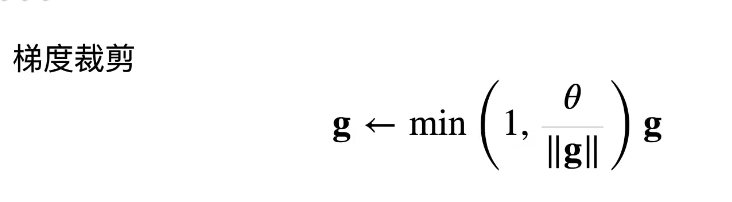

RNN给一个小批量都会做梯度迭代 会容易梯度爆炸


In [60]:
# 梯度剪裁

def grad_clipping(net, theta):  #@save
    """
    裁剪梯度，以防止梯度爆炸。

    参数:
    - net: 目标网络，可以是 PyTorch 的 nn.Module 或者自定义的网络。
    - theta: 裁剪的阈值。

    功能:
    如果梯度的 L2 范数超过给定的阈值 theta，就对梯度进行裁剪。
    """
    # 检查 net 是否是 nn.Module 类型
    if isinstance(net, nn.Module):
        # 获取所有需要梯度计算的参数
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        # 如果 net 不是 nn.Module，使用其自定义的 params
        params = net.params
    
    # 计算所有参数梯度的 L2 范数
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    
    # 如果 L2 范数超过阈值 theta，就进行裁剪
    if norm > theta:
        for param in params:
            # 根据 L2 范数裁剪每个参数的梯度
            param.grad[:] *= theta / norm

In [61]:
# 此函数用于训练循环神经网络（RNN）一个迭代周期
#@save
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """
    训练网络一个迭代周期（定义见第8章）。
    
    参数:
    - net: 神经网络模型。
    - train_iter: 训练数据迭代器，提供输入和目标输出。
    - loss: 损失函数，用于计算损失。
    - updater: 优化器或自定义更新器。
    - device: 设备（CPU 或 GPU）。
    - use_random_iter: 是否使用随机迭代器进行训练。

    返回:
    - 训练集的困惑度和样本数每秒。
    """
    state, timer = None, d2l.Timer()  # 初始化隐状态和计时器
    metric = d2l.Accumulator(2)  # 用于计算训练损失之和和词元数量

    for X, Y in train_iter:  # 遍历训练数据
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机采样时初始化隐状态
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            # 对于 LSTM 或实现的模型，我们需要分离先前的状态来避免累计梯度
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # 如果是nn.GRU，状态是张量
                state.detach_()
            else:
                # 如果是nn.LSTM或从零开始实现的模型，状态是一个元组
                for s in state:
                    s.detach_()

        # 转换目标 Y 的形状
        y = Y.T.reshape(-1)  # 变形为一维张量
        # 将输入和目标移动到指定的设备
        X, y = X.to(device), y.to(device)

        # 前向传播，获取预测的输出和新的隐状态
        y_hat, state = net(X, state)
        # 计算损失
        l = loss(y_hat, y.long()).mean()
        
        # 优化器中的梯度更新
        if isinstance(updater, torch.optim.Optimizer):
            # 如果 updater 是优化器
            updater.zero_grad()  # 清除先前的梯度
            l.backward()  # 反向传播计算梯度
            grad_clipping(net, 1)  # 裁剪梯度，避免梯度爆炸
            updater.step()  # 更新参数
        else:
            # 如果使用自定义更新器
            l.backward()  # 反向传播计算梯度
            grad_clipping(net, 1)  # 裁剪梯度
            # 因为已经调用了 mean 函数，所以使用 batch_size=1 更新
            updater(batch_size=1)

        # 累计损失和词元数量
        metric.add(l * y.numel(), y.numel())
    
    # 返回训练集的困惑度和每秒样本数量
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [62]:
#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """
    训练模型（定义见第8章）。

    参数:
    - net: 要训练的神经网络模型。
    - train_iter: 训练数据的迭代器。
    - vocab: 词汇表，包含词汇到索引的映射。
    - lr: 学习率。
    - num_epochs: 训练的轮数。
    - device: 设备（CPU 或 GPU）。
    - use_random_iter: 是否使用随机迭代器进行训练。
    """
    
    # 定义交叉熵损失函数
    loss = nn.CrossEntropyLoss()
    
    # 创建一个动画工具，用于可视化训练过程
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    
    # 初始化优化器
    if isinstance(net, nn.Module):
        # 如果 net 是 nn.Module 类型，使用 SGD 优化器
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        # 否则，使用自定义的 SGD 更新器
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    
    # 定义用于生成预测的函数
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)

    # 训练和预测
    for epoch in range(num_epochs):
        # 调用 train_epoch_ch8 函数进行一个时期的训练
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        
        # 每训练10个周期进行一次预测
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))  # 进行字符生成预测
            animator.add(epoch + 1, [ppl])  # 记录困惑度变化
    
    # 打印最终的困惑度和处理速度
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    
    # 进行最终预测
    print(predict('time traveller'))
    print(predict('traveller'))

困惑度 1.0, 80082.0 词元/秒 cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


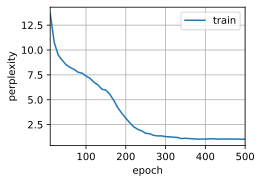

In [63]:
# 开始训练

num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

困惑度 1.5, 61846.9 词元/秒 cuda:0
time travellerit s against reason said filby an argumentative pe
travellerit s against reason said filby an argumentative pe


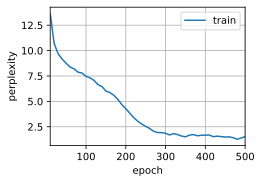

In [64]:
# 我们使用随机采样的方法
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)

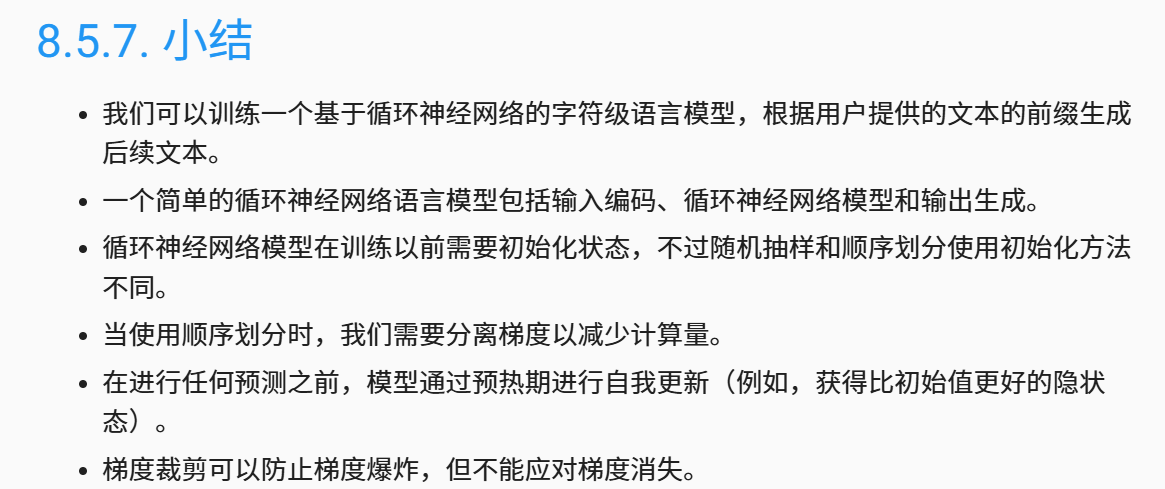

# RNN的简洁实现

In [65]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [66]:
num_hiddens = 256

# 用pytorch在RNN类定义模型
rnn_layer = nn.RNN(len(vocab), num_hiddens)

In [67]:
#手动初始化隐藏状态
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

In [68]:
# 通过一个隐藏状态和一个输入 我们可以用更新后的隐藏状态计算输出
# 创建一个形状为 (num_steps, batch_size, len(vocab)) 的随机输入张量 X
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
# 通过 RNN 层进行前向传播，获取输出 Y 和新的隐状态 state_new
Y, state_new = rnn_layer(X, state)

Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

In [69]:
# 创建RNN类
#@save
class RNNModel(nn.Module):
    """循环神经网络模型"""
    
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        """
        初始化 RNN 模型.
        
        参数:
        - rnn_layer: RNN 层的实例（如 LSTM 或 GRU）。
        - vocab_size: 词汇表的大小，用于输出层。
        - **kwargs: 其他参数，传递给父类 nn.Module 的构造函数。
        """
        super(RNNModel, self).__init__(**kwargs)  # 调用父类 (nn.Module) 的构造函数
        self.rnn = rnn_layer  # 保存 RNN 层
        self.vocab_size = vocab_size  # 保存词汇表大小
        self.num_hiddens = self.rnn.hidden_size  # 获取隐藏层的大小

        # 检查 RNN 是否是双向的
        if not self.rnn.bidirectional:
            self.num_directions = 1  # 单向 RNN
            # 定义从隐藏层到输出层的全连接层
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2  # 双向 RNN
            # 对于双向 RNN，输入的尺寸是隐藏单元数 * 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        """
        前向传播函数.
        
        参数:
        - inputs: 输入张量，包含序列数据。
        - state: 隐状态。

        返回:
        - output: 模型的输出，经过全连接层处理。
        - state: 更新后的隐状态。
        """
        # 将输入转换为独热编码，并将其类型转换为浮点数
        X = F.one_hot(inputs.T.long(), self.vocab_size)  
        X = X.to(torch.float32)  # 转换为浮点类型
        
        # 进行 RNN 的前向传播
        Y, state = self.rnn(X, state)
        
        # 通过全连接层生成输出
        # 将 Y 的形状从 (时间步数, 批量大小, 隐藏单元数) 改为 (时间步数 * 批量大小, 隐藏单元数)
        # 输出形状为 (时间步数 * 批量大小, 词汇大小)
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        
        return output, state  # 返回输出和隐状态

    def begin_state(self, device, batch_size=1):
        """
        初始化隐状态.
        
        参数:
        - device: 计算设备 (CPU 或 GPU)。
        - batch_size: 每个批次的样本数量 (默认为1)。

        返回:
        - 初始化的隐状态，可以是张量或包含两个张量的元组，具体取决于 RNN 的类型。
        """
        if not isinstance(self.rnn, nn.LSTM):
            # 对于 GRU，返回的隐状态是一个张量
            return torch.zeros((self.num_directions * self.rnn.num_layers,
                                batch_size, self.num_hiddens),
                               device=device)
        else:
            # 对于 LSTM，返回的隐状态是一个元组，包含两个张量
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

In [70]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
d2l.predict_ch8('time traveller', 10, net, vocab, device)

'time travellervvvsvvsvvs'

perplexity 1.3, 310225.0 tokens/sec on cuda:0
time traveller aftereo the erevesibl of over think in folentyong
travellerry somo s wi beepraco as hat wallaventhat fallan t


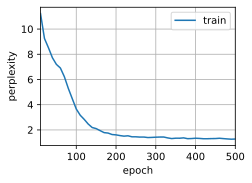

In [71]:
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)

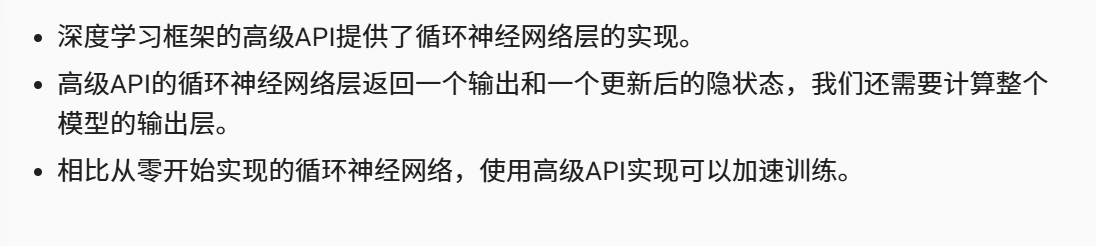